## Before Augmentation

Training data shape: (1944, 22)
Test data shape: (677, 22)


c:\Reza Gonabadi\Polimi\Master Thesis\python-new-env\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Reza Gonabadi\Polimi\Master Thesis\python-new-env\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

Train Results
            Classifier   Bal_Acc  Sensitivity  Specificity   ROC AUC  F1-score
0        Random Forest  0.929790     0.943820     0.915759  0.980084  0.727273
1             AdaBoost  0.840985     0.870787     0.811184  0.922238  0.522766
2              XGBoost  0.942156     0.921348     0.962963  0.973717  0.834606
3        Decision Tree  0.914621     0.853933     0.975309  0.914621  0.835165
4  K-Nearest Neighbors  0.825639     0.876404     0.774873  0.863798  0.484472
5  Logistic Regression  0.818040     0.747191     0.888889  0.869399  0.573276

Validation Results
            Classifier   Bal_Acc  Sensitivity  Specificity   ROC AUC  F1-score
0        Random Forest  0.890149     0.911111     0.869186  0.949903  0.625954
1             AdaBoost  0.856298     0.866667     0.845930  0.943637  0.569343
2              XGBoost  0.885788     0.911111     0.860465  0.941214  0.611940
3        Decision Tree  0.767506     0.622222     0.912791  0.767506  0.543689
4  K-Nearest Neigh

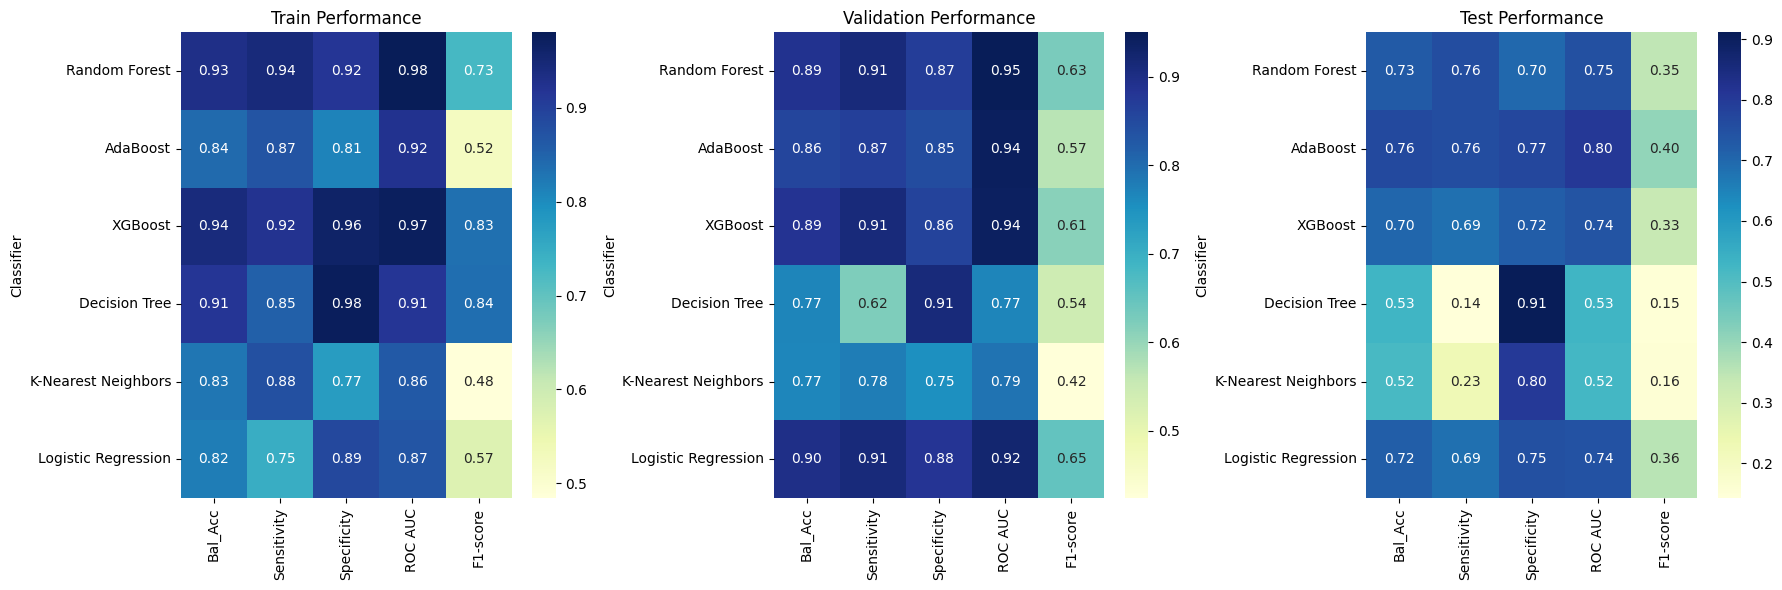

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, f1_score
from sklearn.utils import resample

# Directories for the datasets
output_directory_train = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_low_asus_Output"
output_directory_test = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_under80_Output"

# Path to the CSV files
radiomics_csv_path_train = os.path.join(output_directory_train, 'all_radiomics_features.csv')
radiomics_csv_path_test = os.path.join(output_directory_test, 'all_radiomics_features.csv')

# Read the CSV files into pandas DataFrames
radiomics_df_train = pd.read_csv(radiomics_csv_path_train)
radiomics_df_test = pd.read_csv(radiomics_csv_path_test)

# Filter rows where "Mask" column contains "consensus"
radiomics_df_train = radiomics_df_train[radiomics_df_train["Mask"].str.contains("consensus", na=False)]
radiomics_df_test = radiomics_df_test[radiomics_df_test["Mask"].str.contains("consensus", na=False)]

# Remove overlapping patients between training and test datasets
patient_id_column = 'Patient_ID'  # Replace with the actual column name if different
additional_patient_ids = radiomics_df_test[patient_id_column].unique()
radiomics_df_train = radiomics_df_train[~radiomics_df_train[patient_id_column].isin(additional_patient_ids)]

# Assuming 'Malignancy' is the target column
target_column = 'Malignancy'

#Dynamically filter the columns to match the selected feature names
# selected_features = [
#     'MinorAxisLength', 'Sphericity', 'Elongation'
#  ]
selected_features = [
    'MinorAxisLength', 'SurfaceArea', 'Maximum2DDiameterRow',
    'Maximum2DDiameterColumn', 'MajorAxisLength', 'MeshVolume',
    'Maximum2DDiameterSlice', 'Maximum3DDiameter', 'SurfaceVolumeRatio',
    'VoxelVolume', 'firstorder_Variance', 'HLL_firstorder_Skewness',
    'HHL_firstorder_Uniformity', 'Sphericity'
]

filtered_feature_columns = [
   col for col in radiomics_df_train.columns if any(feature in col for feature in selected_features)
]

#filtered_feature_columns = [col for col in radiomics_df_train.columns if col.startswith('original_shape')]

# Extract features (X) and target (y) for training and test data
X_train = radiomics_df_train[filtered_feature_columns]
y_train = radiomics_df_train[target_column].apply(lambda label: 1 if label == 'Malignant' else 0)

X_test = radiomics_df_test[filtered_feature_columns]
y_test = radiomics_df_test[target_column].apply(lambda label: 1 if label == 'Malignant' else 0)

# Verify dataset shapes
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Calculate class weights
class_weights = {0: 1, 1: 6}  # Adjustable ratio

# Initialize classifiers with class weights
classifiers = {
    'Random Forest': RandomForestClassifier(class_weight=class_weights, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),  # AdaBoost does not directly support class weights
    'XGBoost': XGBClassifier(scale_pos_weight=class_weights[1], random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight=class_weights, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),  # Does not support class weights directly
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42)
}

from sklearn.model_selection import train_test_split

# Split training data into train and validation sets (80% train, 20% validation)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Initialize empty lists to store results
train_results = []
val_results = []
test_results = []

# Number of bootstraps
n_bootstraps = 20

# Perform bootstrapping
for clf_name, clf in classifiers.items():
    accuracy_train, recall_train, specificity_train, roc_auc_train, f1_train = [], [], [], [], []
    accuracy_val, recall_val, specificity_val, roc_auc_val, f1_val = [], [], [], [], []
    accuracy_test, recall_test, specificity_test, roc_auc_test, f1_test = [], [], [], [], []
    
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        X_resampled, y_resampled = resample(X_train_split, y_train_split, random_state=42)

        # Train the model
        clf.fit(X_resampled, y_resampled)

        # Define a function to compute metrics
        def evaluate(X, y):
            y_pred_proba = clf.predict_proba(X)[:, 1] if hasattr(clf, "predict_proba") else None
            fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
            optimal_threshold = thresholds[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))]
            y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
            cm = confusion_matrix(y, y_pred_optimal)
            specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
            return [
                balanced_accuracy_score(y, y_pred_optimal),
                recall_score(y, y_pred_optimal),
                specificity,
                roc_auc_score(y, y_pred_proba) if y_pred_proba is not None else np.nan,
                f1_score(y, y_pred_optimal)
            ]
        
        # Compute metrics for train, validation, and test sets
        train_metrics = evaluate(X_train_split, y_train_split)
        val_metrics = evaluate(X_val, y_val)
        test_metrics = evaluate(X_test, y_test)
        
        # Append metrics to bootstrap lists
        accuracy_train.append(train_metrics[0])
        recall_train.append(train_metrics[1])
        specificity_train.append(train_metrics[2])
        roc_auc_train.append(train_metrics[3])
        f1_train.append(train_metrics[4])
        
        accuracy_val.append(val_metrics[0])
        recall_val.append(val_metrics[1])
        specificity_val.append(val_metrics[2])
        roc_auc_val.append(val_metrics[3])
        f1_val.append(val_metrics[4])
        
        accuracy_test.append(test_metrics[0])
        recall_test.append(test_metrics[1])
        specificity_test.append(test_metrics[2])
        roc_auc_test.append(test_metrics[3])
        f1_test.append(test_metrics[4])
    
    # Calculate mean metrics
    train_results.append([clf_name, np.mean(accuracy_train), np.mean(recall_train), np.mean(specificity_train), np.mean(roc_auc_train), np.mean(f1_train)])
    val_results.append([clf_name, np.mean(accuracy_val), np.mean(recall_val), np.mean(specificity_val), np.mean(roc_auc_val), np.mean(f1_val)])
    test_results.append([clf_name, np.mean(accuracy_test), np.mean(recall_test), np.mean(specificity_test), np.mean(roc_auc_test), np.mean(f1_test)])

# Convert results into DataFrames
train_columns = ['Classifier', 'Bal_Acc', 'Sensitivity', 'Specificity', 'ROC AUC', 'F1-score']
val_columns = ['Classifier', 'Bal_Acc', 'Sensitivity', 'Specificity', 'ROC AUC', 'F1-score']
test_columns = ['Classifier', 'Bal_Acc', 'Sensitivity', 'Specificity', 'ROC AUC', 'F1-score']

train_results_df = pd.DataFrame(train_results, columns=train_columns)
val_results_df = pd.DataFrame(val_results, columns=val_columns)
test_results_df = pd.DataFrame(test_results, columns=test_columns)

# Print the tables
print("Train Results")
print(train_results_df)
print("\nValidation Results")
print(val_results_df)
print("\nTest Results")
print(test_results_df)

# Plot heatmaps for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(train_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[0])
axes[0].set_title("Train Performance")

sns.heatmap(val_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[1])
axes[1].set_title("Validation Performance")

sns.heatmap(test_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[2])
axes[2].set_title("Test Performance")

plt.tight_layout()
plt.show()



In [2]:
radiomics_df_train

,Patient_ID,Nodule_ID,Mask,Image,Mean,Std,Max,Min,Malignancy,diagnostics_Versions_PyRadiomics,...,wavelet-LLL_gldm_GrayLevelNonUniformity,wavelet-LLL_gldm_GrayLevelVariance,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
0,LIDC-IDRI-0001,LIDC-IDRI-0001_nodule_1,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,639.275055,174.073389,1049.0,131.0,Malignant,3.1.0a2.post24+gdea5faf,...,107.637436,344.989452,3609.423360,8.428519,40726.114591,0.002982,0.000893,0.489313,1377.437834,0.000658
5,LIDC-IDRI-0002,LIDC-IDRI-0002_nodule_1,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,248.719478,117.298008,1068.0,53.0,Malignant,3.1.0a2.post24+gdea5faf,...,360.566096,170.439468,640.290415,21.030592,6693.843180,0.368916,0.008520,0.237330,269.119004,0.001153
8,LIDC-IDRI-0003,LIDC-IDRI-0003_nodule_1,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,257.833202,94.257075,773.0,31.0,Benign,3.1.0a2.post24+gdea5faf,...,80.898505,80.809385,538.553895,8.524784,4334.051928,0.039453,0.005745,0.345710,192.928433,0.002616
10,LIDC-IDRI-0003,LIDC-IDRI-0003_nodule_2,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,571.294045,158.053146,911.0,138.0,Malignant,3.1.0a2.post24+gdea5faf,...,60.815489,289.473762,2438.901882,5.834927,19283.803456,0.004059,0.001376,0.529399,1042.384826,0.001011
15,LIDC-IDRI-0003,LIDC-IDRI-0003_nodule_3,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,421.325670,192.172489,911.0,94.0,Benign,3.1.0a2.post24+gdea5faf,...,5.329502,273.756844,1176.287356,2.739464,3592.693487,0.013798,0.009151,0.700165,767.644929,0.008259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9392,LIDC-IDRI-1011,LIDC-IDRI-1011_nodule_1,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,344.699844,184.970846,859.0,0.0,Benign,3.1.0a2.post24+gdea5faf,...,50.972006,356.565479,2195.868118,5.516952,9621.673406,0.054460,0.004273,0.532285,1229.942224,0.001160
9397,LIDC-IDRI-1011,LIDC-IDRI-1011_nodule_2,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,584.966869,168.439876,973.0,143.0,Malignant,3.1.0a2.post24+gdea5faf,...,35.543164,327.203796,2524.507699,5.663556,20558.187587,0.007227,0.002233,0.587737,1188.416746,0.001214
9402,LIDC-IDRI-1011,LIDC-IDRI-1011_nodule_3,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,600.952257,150.961359,952.0,183.0,Malignant,3.1.0a2.post24+gdea5faf,...,21.901042,252.522858,1808.318576,4.967014,11990.091146,0.005757,0.002797,0.561541,831.051672,0.002325
9407,LIDC-IDRI-1011,LIDC-IDRI-1011_nodule_4,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,286.352941,49.317031,399.0,180.0,Benign,3.1.0a2.post24+gdea5faf,...,2.882353,26.003460,141.882353,4.411765,681.764706,0.287642,0.083561,0.473856,62.336601,0.035298


In [3]:
radiomics_df_train.Malignancy.value_counts()

Malignancy
Benign       1721
Malignant     223
Name: count, dtype: int64

In [4]:
y_train.value_counts()

Malignancy
0    1721
1     223
Name: count, dtype: int64

### Using MLP

Training data shape: (1944, 3)
Test data shape: (677, 3)
Train Results
  Classifier  Balanced Accuracy  Sensitivity  Specificity   ROC AUC  F1-score
0        MLP           0.849816     0.842697     0.856935  0.910214  0.571429

Validation Results
  Classifier  Balanced Accuracy  Sensitivity  Specificity   ROC AUC  F1-score
0        MLP           0.908527     0.933333     0.883721  0.949289  0.661417

Test Results
  Classifier  Balanced Accuracy  Sensitivity  Specificity   ROC AUC  F1-score
0        MLP           0.810755     0.771429     0.850082  0.852059  0.502326


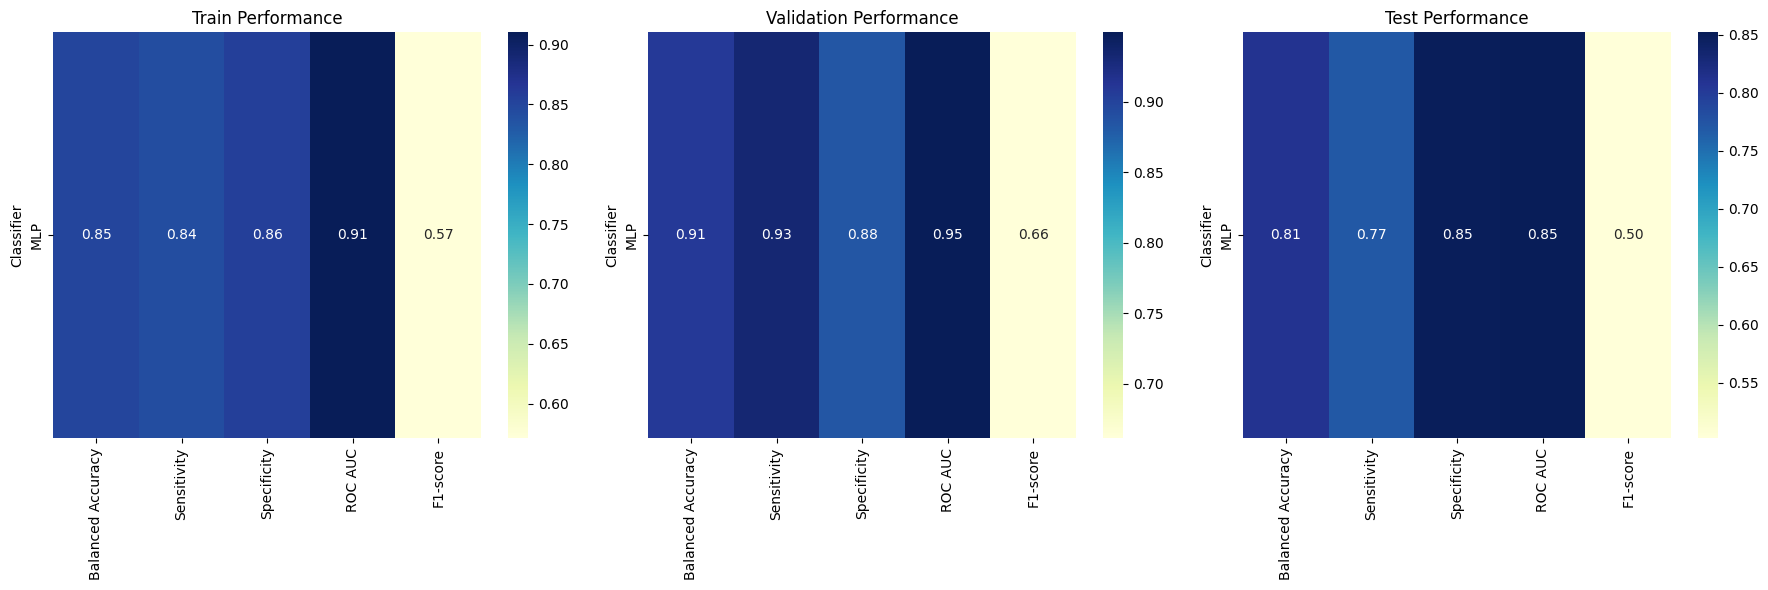

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, f1_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Directories for the datasets
output_directory_train = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_low_asus_Output"
output_directory_test = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_under80_Output"

# Path to the CSV files
radiomics_csv_path_train = os.path.join(output_directory_train, 'all_radiomics_features.csv')
radiomics_csv_path_test = os.path.join(output_directory_test, 'all_radiomics_features.csv')

# Read the CSV files
radiomics_df_train = pd.read_csv(radiomics_csv_path_train)
radiomics_df_test = pd.read_csv(radiomics_csv_path_test)

# Filter rows where "Mask" contains "consensus"
radiomics_df_train = radiomics_df_train[radiomics_df_train["Mask"].str.contains("consensus", na=False)]
radiomics_df_test = radiomics_df_test[radiomics_df_test["Mask"].str.contains("consensus", na=False)]

# Remove overlapping patients
patient_id_column = 'Patient_ID'
additional_patient_ids = radiomics_df_test[patient_id_column].unique()
radiomics_df_train = radiomics_df_train[~radiomics_df_train[patient_id_column].isin(additional_patient_ids)]

# Target column
target_column = 'Malignancy'

# Selected features
selected_features = ['MinorAxisLength', 'Sphericity', 'Elongation']
filtered_feature_columns = [col for col in radiomics_df_train.columns if any(feature in col for feature in selected_features)]

# Extract features and target
X_train = radiomics_df_train[filtered_feature_columns]
y_train = radiomics_df_train[target_column].apply(lambda label: 1 if label == 'Malignant' else 0)

X_test = radiomics_df_test[filtered_feature_columns]
y_test = radiomics_df_test[target_column].apply(lambda label: 1 if label == 'Malignant' else 0)

# Verify shapes
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Split into train/validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Initialize MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

# Results storage
train_results = []
val_results = []
test_results = []

# Bootstrapping parameters
n_bootstraps = 20

# Perform bootstrapping
balanced_accuracy_train, recall_train, specificity_train, roc_auc_train, f1_train = [], [], [], [], []
balanced_accuracy_val, recall_val, specificity_val, roc_auc_val, f1_val = [], [], [], [], []
balanced_accuracy_test, recall_test, specificity_test, roc_auc_test, f1_test = [], [], [], [], []

for _ in range(n_bootstraps):
    # Bootstrap resampling
    X_resampled, y_resampled = resample(X_train_split, y_train_split, random_state=42)

    # Train
    mlp_clf.fit(X_resampled, y_resampled)

    # Evaluation function
    def evaluate(X, y):
        y_pred_proba = mlp_clf.predict_proba(X)[:, 1] if hasattr(mlp_clf, "predict_proba") else None
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
        optimal_threshold = thresholds[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))]
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
        cm = confusion_matrix(y, y_pred_optimal)
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
        return [
            balanced_accuracy_score(y, y_pred_optimal),
            recall_score(y, y_pred_optimal),
            specificity,
            roc_auc_score(y, y_pred_proba) if y_pred_proba is not None else np.nan,
            f1_score(y, y_pred_optimal)
        ]

    # Compute metrics
    train_metrics = evaluate(X_train_split, y_train_split)
    val_metrics = evaluate(X_val, y_val)
    test_metrics = evaluate(X_test, y_test)

    # Store metrics
    balanced_accuracy_train.append(train_metrics[0])
    recall_train.append(train_metrics[1])
    specificity_train.append(train_metrics[2])
    roc_auc_train.append(train_metrics[3])
    f1_train.append(train_metrics[4])

    balanced_accuracy_val.append(val_metrics[0])
    recall_val.append(val_metrics[1])
    specificity_val.append(val_metrics[2])
    roc_auc_val.append(val_metrics[3])
    f1_val.append(val_metrics[4])

    balanced_accuracy_test.append(test_metrics[0])
    recall_test.append(test_metrics[1])
    specificity_test.append(test_metrics[2])
    roc_auc_test.append(test_metrics[3])
    f1_test.append(test_metrics[4])

# Collect mean results
train_results.append(['MLP', np.mean(balanced_accuracy_train), np.mean(recall_train), np.mean(specificity_train), np.mean(roc_auc_train), np.mean(f1_train)])
val_results.append(['MLP', np.mean(balanced_accuracy_val), np.mean(recall_val), np.mean(specificity_val), np.mean(roc_auc_val), np.mean(f1_val)])
test_results.append(['MLP', np.mean(balanced_accuracy_test), np.mean(recall_test), np.mean(specificity_test), np.mean(roc_auc_test), np.mean(f1_test)])

# Create DataFrames
columns = ['Classifier', 'Balanced Accuracy', 'Sensitivity', 'Specificity', 'ROC AUC', 'F1-score']

train_results_df = pd.DataFrame(train_results, columns=columns)
val_results_df = pd.DataFrame(val_results, columns=columns)
test_results_df = pd.DataFrame(test_results, columns=columns)

# Print the results
print("Train Results")
print(train_results_df)

print("\nValidation Results")
print(val_results_df)

print("\nTest Results")
print(test_results_df)

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(train_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[0])
axes[0].set_title("Train Performance")

sns.heatmap(val_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[1])
axes[1].set_title("Validation Performance")

sns.heatmap(test_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[2])
axes[2].set_title("Test Performance")

plt.tight_layout()
plt.show()


## After Augmentation

C:\Users\Reza.Gonabadi\AppData\Local\Temp\ipykernel_14096\955794578.py:23: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  radiomics_df_train = pd.read_csv(train_path)


Training data shape: (2836, 3)
Test data shape: (677, 3)
Train Results
            Classifier   Bal_Acc  Sensitivity  Specificity   ROC AUC  F1-score
0        Random Forest  0.974161     0.970852     0.977471  0.991087  0.968139
1             AdaBoost  0.933799     0.929372     0.938227  0.983173  0.918051
2              XGBoost  0.967891     0.964126     0.971657  0.990912  0.960357
3        Decision Tree  0.961196     0.952915     0.969477  0.961196  0.952915
4  K-Nearest Neighbors  0.932230     0.947309     0.917151  0.976090  0.913020
5  Logistic Regression  0.937982     0.942825     0.933140  0.981884  0.921644

Validation Results
            Classifier   Bal_Acc  Sensitivity  Specificity   ROC AUC  F1-score
0        Random Forest  0.936069     0.941704     0.930435  0.973848  0.919037
1             AdaBoost  0.938695     0.923767     0.953623  0.980588  0.925843
2              XGBoost  0.926308     0.919283     0.933333  0.973796  0.909091
3        Decision Tree  0.913784     0.9

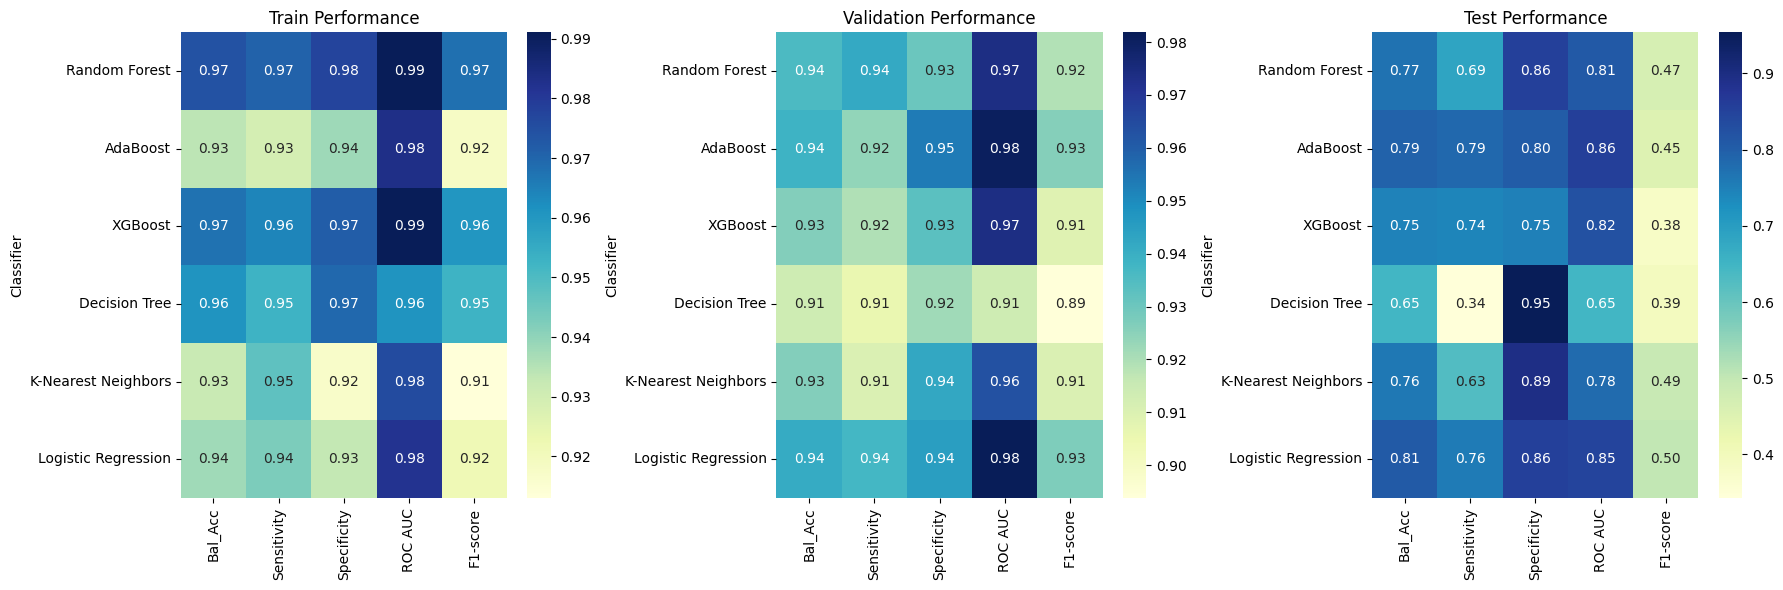

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, f1_score
from sklearn.utils import resample


# === FILE PATHS ===
output_directory_train = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_low_asus_Output"
output_directory_test = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_under80_Output"

train_path = os.path.join(output_directory_train, 'all_nodules_metadata_combined_augmented_new.csv')
test_path = os.path.join(output_directory_test, 'all_radiomics_features.csv')

# === LOAD DATA ===
radiomics_df_train = pd.read_csv(train_path)
radiomics_df_test = pd.read_csv(test_path)

# === KEEP consensus + augmented IN TRAINING ===
# (No filtering for training — keep everything)

# === KEEP ONLY consensus IN TEST ===
radiomics_df_train = radiomics_df_train[radiomics_df_train["Mask"].str.contains("aug|consensus", na=False)]
radiomics_df_test = radiomics_df_test[radiomics_df_test["Mask"].str.contains("consensus", na=False)]

# === REMOVE PATIENTS FROM TRAINING IF THEY EXIST IN TEST ===
patient_id_column = 'Patient_ID'  # update if different
test_patient_ids = radiomics_df_test[patient_id_column].unique()
radiomics_df_train = radiomics_df_train[~radiomics_df_train[patient_id_column].isin(test_patient_ids)]


# Assuming 'Malignancy' is the target column
target_column = 'Malignancy'

# Dynamically filter the columns to match the selected feature names
selected_features = [
    'MinorAxisLength', 'Sphericity', 'Elongation'
 ]
# selected_features = [
#     'MinorAxisLength', 'SurfaceArea', 'Maximum2DDiameterRow',
#     'Maximum2DDiameterColumn', 'MajorAxisLength', 'MeshVolume',
#     'Maximum2DDiameterSlice', 'Maximum3DDiameter', 'SurfaceVolumeRatio',
#     'VoxelVolume', 'firstorder_Variance', 'HLL_firstorder_Skewness',
#     'HHL_firstorder_Uniformity', 'Sphericity'
# ]

filtered_feature_columns = [
   col for col in radiomics_df_train.columns if any(feature in col for feature in selected_features)
]

#filtered_feature_columns = [col for col in radiomics_df_train.columns if col.startswith('original_shape')]

# Extract features (X) and target (y) for training and test data
X_train = radiomics_df_train[filtered_feature_columns]
y_train = radiomics_df_train[target_column].apply(lambda label: 1 if label == 'Malignant' else 0)

X_test = radiomics_df_test[filtered_feature_columns]
y_test = radiomics_df_test[target_column].apply(lambda label: 1 if label == 'Malignant' else 0)

# Verify dataset shapes
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


# Initialize classifiers without class weights
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42)
}

from sklearn.model_selection import train_test_split

# Split training data into train and validation sets (80% train, 20% validation)
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Initialize empty lists to store results
train_results = []
val_results = []
test_results = []

# Number of bootstraps
n_bootstraps = 20

# Perform bootstrapping
for clf_name, clf in classifiers.items():
    accuracy_train, recall_train, specificity_train, roc_auc_train, f1_train = [], [], [], [], []
    accuracy_val, recall_val, specificity_val, roc_auc_val, f1_val = [], [], [], [], []
    accuracy_test, recall_test, specificity_test, roc_auc_test, f1_test = [], [], [], [], []
    
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        X_resampled, y_resampled = resample(X_train_split, y_train_split, random_state=42)

        # Train the model
        clf.fit(X_resampled, y_resampled)

        # Define a function to compute metrics
        def evaluate(X, y):
            y_pred_proba = clf.predict_proba(X)[:, 1] if hasattr(clf, "predict_proba") else None
            fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
            optimal_threshold = thresholds[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))]
            y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
            cm = confusion_matrix(y, y_pred_optimal)
            specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
            return [
                balanced_accuracy_score(y, y_pred_optimal),
                recall_score(y, y_pred_optimal),
                specificity,
                roc_auc_score(y, y_pred_proba) if y_pred_proba is not None else np.nan,
                f1_score(y, y_pred_optimal)
            ]
        
        # Compute metrics for train, validation, and test sets
        train_metrics = evaluate(X_train_split, y_train_split)
        val_metrics = evaluate(X_val, y_val)
        test_metrics = evaluate(X_test, y_test)
        
        # Append metrics to bootstrap lists
        accuracy_train.append(train_metrics[0])
        recall_train.append(train_metrics[1])
        specificity_train.append(train_metrics[2])
        roc_auc_train.append(train_metrics[3])
        f1_train.append(train_metrics[4])
        
        accuracy_val.append(val_metrics[0])
        recall_val.append(val_metrics[1])
        specificity_val.append(val_metrics[2])
        roc_auc_val.append(val_metrics[3])
        f1_val.append(val_metrics[4])
        
        accuracy_test.append(test_metrics[0])
        recall_test.append(test_metrics[1])
        specificity_test.append(test_metrics[2])
        roc_auc_test.append(test_metrics[3])
        f1_test.append(test_metrics[4])
    
    # Calculate mean metrics
    train_results.append([clf_name, np.mean(accuracy_train), np.mean(recall_train), np.mean(specificity_train), np.mean(roc_auc_train), np.mean(f1_train)])
    val_results.append([clf_name, np.mean(accuracy_val), np.mean(recall_val), np.mean(specificity_val), np.mean(roc_auc_val), np.mean(f1_val)])
    test_results.append([clf_name, np.mean(accuracy_test), np.mean(recall_test), np.mean(specificity_test), np.mean(roc_auc_test), np.mean(f1_test)])

# Convert results into DataFrames
train_columns = ['Classifier', 'Bal_Acc', 'Sensitivity', 'Specificity', 'ROC AUC', 'F1-score']
val_columns = ['Classifier', 'Bal_Acc', 'Sensitivity', 'Specificity', 'ROC AUC', 'F1-score']
test_columns = ['Classifier', 'Bal_Acc', 'Sensitivity', 'Specificity', 'ROC AUC', 'F1-score']

train_results_df = pd.DataFrame(train_results, columns=train_columns)
val_results_df = pd.DataFrame(val_results, columns=val_columns)
test_results_df = pd.DataFrame(test_results, columns=test_columns)

# Print the tables
print("Train Results")
print(train_results_df)
print("\nValidation Results")
print(val_results_df)
print("\nTest Results")
print(test_results_df)

# Plot heatmaps for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(train_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[0])
axes[0].set_title("Train Performance")

sns.heatmap(val_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[1])
axes[1].set_title("Validation Performance")

sns.heatmap(test_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[2])
axes[2].set_title("Test Performance")

plt.tight_layout()
plt.show()



In [4]:
y_train.value_counts()

Malignancy
0    1721
1    1115
Name: count, dtype: int64

In [3]:
radiomics_df_train.head()

,Patient_ID,Nodule_ID,Mask,Image,Mean,Std,Max,Min,Malignancy,diagnostics_Versions_PyRadiomics,...,wavelet-LLL_gldm_GrayLevelNonUniformity,wavelet-LLL_gldm_GrayLevelVariance,wavelet-LLL_gldm_HighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceEmphasis,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis
0,LIDC-IDRI-0001,1,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,NaN,NaN,NaN,NaN,Malignant,0+unknown,...,447.536101,886.770698,2280.765652,16.552312,20659.765160,0.149318,0.004743,0.362434,1026.445184,0.000876
1,LIDC-IDRI-0001,1,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,NaN,NaN,NaN,NaN,Malignant,0+unknown,...,47.904358,1136.910711,2869.722128,1.219581,3430.205433,0.007803,0.006096,0.946362,2732.901308,0.005679
2,LIDC-IDRI-0001,1,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,NaN,NaN,NaN,NaN,Malignant,0+unknown,...,748.371992,1315.793968,3656.784006,30.017320,56656.196100,0.156058,0.003345,0.249012,1237.442699,0.000481
3,LIDC-IDRI-0001,1,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,NaN,NaN,NaN,NaN,Malignant,0+unknown,...,423.956773,1160.506417,3466.026836,25.971997,38941.536450,0.121144,0.002605,0.333786,1446.426694,0.000507
4,LIDC-IDRI-0002,1,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDR...,NaN,NaN,NaN,NaN,Malignant,0+unknown,...,1431.322071,1241.390232,2736.959976,37.462946,29028.627960,0.440446,0.005650,0.236968,1225.920702,0.000407


### Using MLP

C:\Users\Reza.Gonabadi\AppData\Local\Temp\ipykernel_14096\4048851990.py:21: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  radiomics_df_train = pd.read_csv(train_path)


Train Results
  Classifier   Bal_Acc  Sensitivity  Specificity   ROC AUC  F1-score
0        MLP  0.934256     0.936099     0.932413  0.981363  0.917582

Validation Results
  Classifier   Bal_Acc  Sensitivity  Specificity   ROC AUC  F1-score
0        MLP  0.938175      0.93722      0.93913  0.979749  0.922737

Test Results
  Classifier   Bal_Acc  Sensitivity  Specificity   ROC AUC  F1-score
0        MLP  0.810755     0.771429     0.850082  0.851706  0.502326


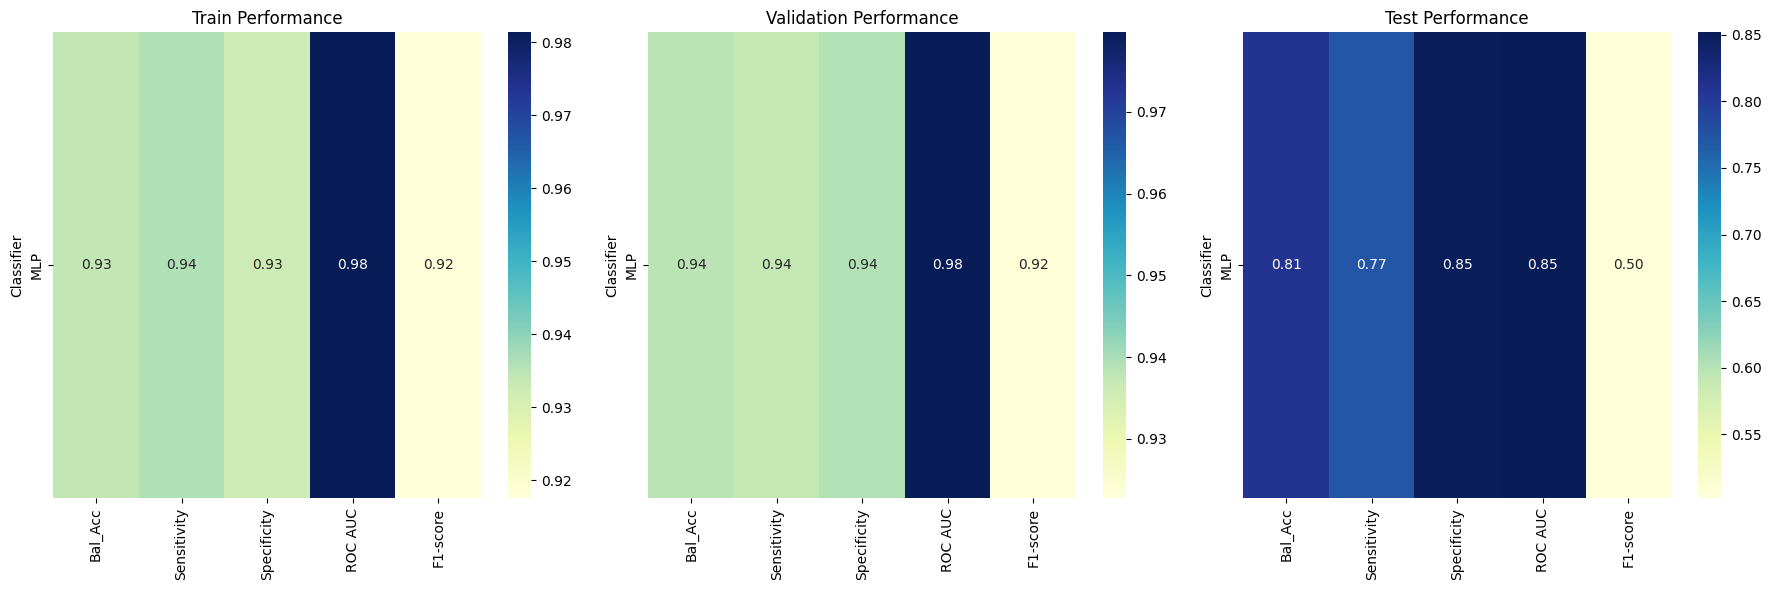

In [9]:
# === IMPORTS ===
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, f1_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === FILE PATHS ===
output_directory_train = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_low_asus_Output"
output_directory_test = r"C:\Reza Gonabadi\Polimi\Master Thesis\LIDC-IDRI_Simplified_under80_Output"

train_path = os.path.join(output_directory_train, 'all_nodules_metadata_combined_augmented_new.csv')
test_path = os.path.join(output_directory_test, 'all_radiomics_features.csv')

# === LOAD DATA ===
radiomics_df_train = pd.read_csv(train_path)
radiomics_df_test = pd.read_csv(test_path)

# === KEEP consensus + augmented IN TRAINING, ONLY consensus IN TEST ===
radiomics_df_train = radiomics_df_train[radiomics_df_train["Mask"].str.contains("aug|consensus", na=False)]
radiomics_df_test = radiomics_df_test[radiomics_df_test["Mask"].str.contains("consensus", na=False)]

# === REMOVE PATIENTS FROM TRAINING IF THEY EXIST IN TEST ===
patient_id_column = 'Patient_ID'
test_patient_ids = radiomics_df_test[patient_id_column].unique()
radiomics_df_train = radiomics_df_train[~radiomics_df_train[patient_id_column].isin(test_patient_ids)]

# === FEATURES SELECTION ===
selected_features = [
    'MinorAxisLength', 'Sphericity', 'Elongation'
]

# selected_features = [
#     'MinorAxisLength', 'SurfaceArea', 'Maximum2DDiameterRow',
#     'Maximum2DDiameterColumn', 'MajorAxisLength', 'MeshVolume',
#     'Maximum2DDiameterSlice', 'Maximum3DDiameter', 'SurfaceVolumeRatio',
#     'VoxelVolume', 'firstorder_Variance', 'HLL_firstorder_Skewness',
#     'HHL_firstorder_Uniformity', 'Sphericity'
# ]

filtered_feature_columns = [
    col for col in radiomics_df_train.columns if any(feature in col for feature in selected_features)
]

# === SPLIT FEATURES/TARGET ===
target_column = 'Malignancy'

X_train = radiomics_df_train[filtered_feature_columns]
y_train = radiomics_df_train[target_column].apply(lambda label: 1 if label == 'Malignant' else 0)

X_test = radiomics_df_test[filtered_feature_columns]
y_test = radiomics_df_test[target_column].apply(lambda label: 1 if label == 'Malignant' else 0)

# === TRAIN/VALIDATION SPLIT ===
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# === SCALING ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# === MLP CLASSIFIER ===
# mlp = MLPClassifier(hidden_layer_sizes=(50, 20), activation='relu', solver='adam', max_iter=500, random_state=42)


mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    random_state=42
)

# === BOOTSTRAPPING TRAINING ===
n_bootstraps = 20

train_results = []
val_results = []
test_results = []

accuracy_train, recall_train, specificity_train, roc_auc_train, f1_train = [], [], [], [], []
accuracy_val, recall_val, specificity_val, roc_auc_val, f1_val = [], [], [], [], []
accuracy_test, recall_test, specificity_test, roc_auc_test, f1_test = [], [], [], [], []

for _ in range(n_bootstraps):
    # Bootstrap sampling
    X_resampled, y_resampled = resample(X_train_scaled, y_train_split, random_state=42)
    
    # Train MLP
    mlp.fit(X_resampled, y_resampled)
    
    # Function to evaluate model
    def evaluate(X, y):
        y_pred_proba = mlp.predict_proba(X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
        optimal_threshold = thresholds[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))]
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
        cm = confusion_matrix(y, y_pred_optimal)
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
        return [
            balanced_accuracy_score(y, y_pred_optimal),
            recall_score(y, y_pred_optimal),
            specificity,
            roc_auc_score(y, y_pred_proba),
            f1_score(y, y_pred_optimal)
        ]
    
    # Collect metrics
    train_metrics = evaluate(X_train_scaled, y_train_split)
    val_metrics = evaluate(X_val_scaled, y_val)
    test_metrics = evaluate(X_test_scaled, y_test)
    
    accuracy_train.append(train_metrics[0])
    recall_train.append(train_metrics[1])
    specificity_train.append(train_metrics[2])
    roc_auc_train.append(train_metrics[3])
    f1_train.append(train_metrics[4])
    
    accuracy_val.append(val_metrics[0])
    recall_val.append(val_metrics[1])
    specificity_val.append(val_metrics[2])
    roc_auc_val.append(val_metrics[3])
    f1_val.append(val_metrics[4])
    
    accuracy_test.append(test_metrics[0])
    recall_test.append(test_metrics[1])
    specificity_test.append(test_metrics[2])
    roc_auc_test.append(test_metrics[3])
    f1_test.append(test_metrics[4])

# === RESULTS SUMMARY ===
train_results.append(['MLP', np.mean(accuracy_train), np.mean(recall_train), np.mean(specificity_train), np.mean(roc_auc_train), np.mean(f1_train)])
val_results.append(['MLP', np.mean(accuracy_val), np.mean(recall_val), np.mean(specificity_val), np.mean(roc_auc_val), np.mean(f1_val)])
test_results.append(['MLP', np.mean(accuracy_test), np.mean(recall_test), np.mean(specificity_test), np.mean(roc_auc_test), np.mean(f1_test)])

# Convert to DataFrame
columns = ['Classifier', 'Bal_Acc', 'Sensitivity', 'Specificity', 'ROC AUC', 'F1-score']
train_results_df = pd.DataFrame(train_results, columns=columns)
val_results_df = pd.DataFrame(val_results, columns=columns)
test_results_df = pd.DataFrame(test_results, columns=columns)

# === PRINT RESULTS ===
print("Train Results")
print(train_results_df)
print("\nValidation Results")
print(val_results_df)
print("\nTest Results")
print(test_results_df)

# === PLOT RESULTS ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(train_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[0])
axes[0].set_title("Train Performance")

sns.heatmap(val_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[1])
axes[1].set_title("Validation Performance")

sns.heatmap(test_results_df.set_index('Classifier'), annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, ax=axes[2])
axes[2].set_title("Test Performance")

plt.tight_layout()
plt.show()
